In [47]:
# Import needed modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud


# Get dataset
reviews = pd.read_csv("../data/gojek_reviews.csv")
reviews.head()

,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,Forgot my airport in his car and I didn't rece...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,So far so good,0,2025-02-23 14:04:35,NaN,NaN,5.10.1,5.10.1
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,NaN,NaN,5.11.1,5.11.1
3,451872f2-472a-4696-a6f9-cb5ed515c6b6,arfandi amiruddin,5,Good,0,2025-02-23 12:46:18,NaN,NaN,5.11.1,5.11.1
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,"The ""play later"" Promo is annoying. Can't use ...",1,2025-02-23 12:32:42,NaN,NaN,4.32.1,4.32.1


# 1. Explore the dataset

### a. Analyze the distribution of review lengths

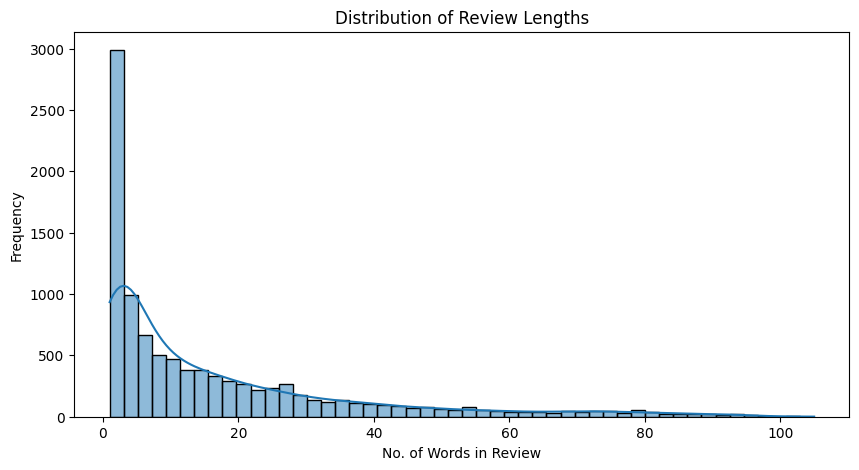

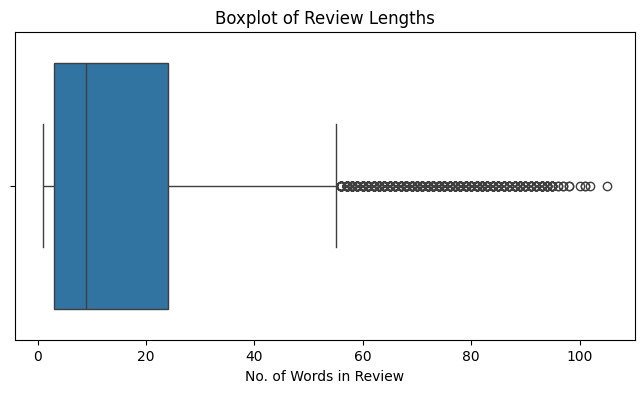

In [48]:
# Add a column for word count
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))

# Histogram to visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(reviews['word_count'], bins=50, kde=True)
plt.xlabel("No. of Words in Review")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=reviews['word_count'])
plt.xlabel("No. of Words in Review")
plt.title("Boxplot of Review Lengths")
plt.show()

The histogram shows a strong right-skewed distribution, meaning most reviews are very short, but the boxplot tells us that there are also many outliers (long reviews).

### b. Identify common words and phrases used in reviews

/var/folders/1b/xct6wpr93gvft6q8bczb_j0w0000gn/T/ipykernel_11973/3597157703.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


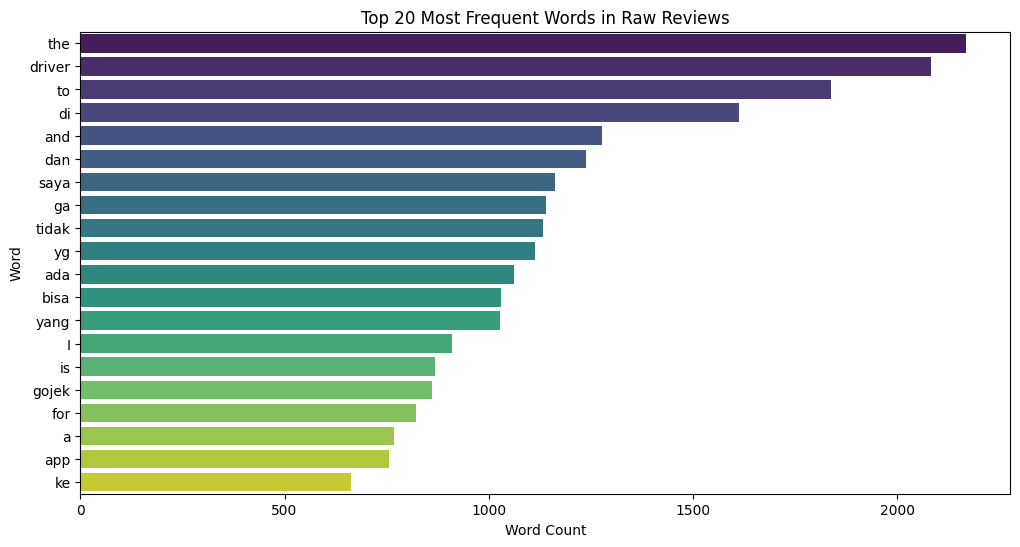

In [49]:
# Join all reviews into one string
all_words = ' '.join(reviews['content'].astype(str)).split()

# Count frequency of each word
word_freq = Counter(all_words)

# Get top 20
most_common_words = word_freq.most_common(20)

# Seperate the words and their frequencies
words, counts = zip(*most_common_words)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Raw Reviews")
plt.show()

### c. Visualize word frequency distributions

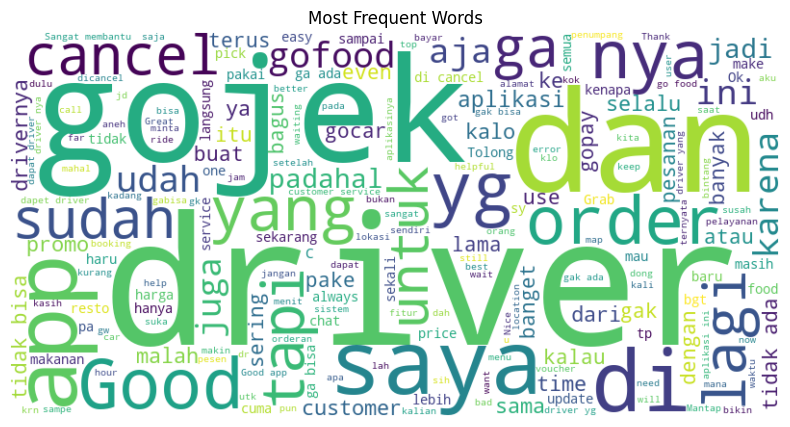

In [50]:
# Creates word cloud based on word frequency
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words")
plt.show()


# 2. Clean and preprocess text data

### a. Convert text to lowercase

In [51]:
# Convert review content to lowercase
reviews['content'] = reviews['content'].str.lower()

### b. Remove stop words, punctuation, and special characters

In [52]:
# Remove punctuation and special characters
import re
reviews['content'] = reviews['content'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) if isinstance(x, str) else x)

# Remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load English stopwords
english_stopwords = set(stopwords.words('english')) 

# Load Indonesian stopwords
id_stopwords_path = "../data/id_stopwords.txt"
id_stopwords = set()

with open(id_stopwords_path, 'r') as file:
    for line in file:
        id_stopwords.add(line.strip())

# Combine English & Indonesian stopwords
all_stopwords = english_stopwords.union(id_stopwords)

def remove_stopwords(text):
    if isinstance(text,str):
        words = text.split()
        filtered_words = [word for word in words if word not in all_stopwords]
        return ' '.join(filtered_words)
    return text

reviews['content'] = reviews['content'].apply(remove_stopwords)
reviews.dropna(subset=['content'], inplace=True)

[nltk_data] Downloading package stopwords to /Users/thata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### c. Tokenization and stemming/lemmatization

In [53]:
# Lemmatize words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

reviews['lemmatized_content'] = reviews['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to /Users/thata/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### d. Handle duplicate or noisy data

In [54]:
# Handle duplicate and noisy data
print(f"Original dataset shape: {reviews.shape}")

# Check and remove duplicates
duplicate_count = reviews.duplicated(subset=['content']).sum()
print(f"Found {duplicate_count} duplicate reviews")
reviews = reviews.drop_duplicates(subset=['content'])

# Remove very short reviews (likely noise)
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))
short_reviews = reviews[reviews['word_count'] < 2].shape[0]
print(f"Removing {short_reviews} very short reviews (less than 2 words)")
reviews = reviews[reviews['word_count'] >= 2]

# Handle missing values in any other columns
missing_values = reviews.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Fill missing numerical values with median (if any)
numerical_cols = reviews.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].median())

# Fill missing categorical/text values with mode (if any)
categorical_cols = reviews.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'content' and col != 'lemmatized_content' and reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].mode()[0])

# Check for outliers in rating (if present)
if 'rating' in reviews.columns:
    print("\nRating distribution:")
    print(reviews['rating'].value_counts())
    
    # Check if there are invalid ratings outside expected range (e.g., 1-5)
    invalid_ratings = reviews[(reviews['rating'] < 1) | (reviews['rating'] > 5)].shape[0]
    if invalid_ratings > 0:
        print(f"Found {invalid_ratings} reviews with invalid ratings")
        # Remove or fix invalid ratings
        reviews = reviews[(reviews['rating'] >= 1) & (reviews['rating'] <= 5)]

print(f"\nCleaned dataset shape: {reviews.shape}")
reviews.head()

Original dataset shape: (10000, 12)
Found 1816 duplicate reviews
Removing 413 very short reviews (less than 2 words)

Missing values in each column:
reviewId                   0
userName                   2
score                      0
content                    0
thumbsUpCount              0
at                         0
replyContent            3111
repliedAt               3111
reviewCreatedVersion    1184
appVersion              1184
word_count                 0
lemmatized_content         0
dtype: int64

Cleaned dataset shape: (7771, 12)


,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion,word_count,lemmatized_content
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,forgot airport car didnt receive infofollow dr...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1,9,forgot airport car didnt receive infofollow dr...
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,far good,0,2025-02-23 14:04:35,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.10.1,5.10.1,2,far good
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.11.1,5.11.1,3,drivernya cakep hehe
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,play later promo annoying cant use anw u keep ...,1,2025-02-23 12:32:42,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,4.32.1,4.32.1,11,play later promo annoying cant use anw u keep ...
5,ac4fed4e-7bf4-4677-b973-98f4d3c9df0f,Husen Badrutamam,1,jelek banget kelakuan drivernya ambil orderan ...,0,2025-02-23 10:36:21,"Hai Kak Husen, mohon maaf atas ketidaknyamanan...",2025-02-23 11:01:14,5.10.1,5.10.1,16,jelek banget kelakuan drivernya ambil orderan ...


# 3. Topic Modelling

### a. Use Latent Dirichlet Allocation (LDA) to identify key topics

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# Convert each review into a list of words
reviews_tokenized = reviews['lemmatized_content'].astype(str).apply(word_tokenize)

# Assign unique ID to each word
id2word = corpora.Dictionary(reviews_tokenized)

# Convert words to Bag-of-Words format
corpus = [id2word.doc2bow(text) for text in reviews_tokenized]

# No. of topics u want to check
num_topics = 5  

# Train the model
lda_model = LdaModel(corpus=corpus, 
                     id2word=id2word, 
                     num_topics=num_topics, 
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)


lda_model.print_topics()


[nltk_data] Downloading package punkt to /Users/thata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[(0,
  '0.069*"driver" + 0.018*"cancel" + 0.016*"gocar" + 0.013*"susah" + 0.012*"drivernya" + 0.011*"dapet" + 0.011*"order" + 0.010*"banget" + 0.009*"titik" + 0.007*"gojek"'),
 (1,
  '0.033*"driver" + 0.023*"app" + 0.012*"gojek" + 0.011*"time" + 0.011*"good" + 0.011*"order" + 0.011*"service" + 0.008*"get" + 0.007*"customer" + 0.007*"cancel"'),
 (2,
  '0.016*"gojek" + 0.014*"promo" + 0.008*"mantap" + 0.007*"akun" + 0.006*"meow" + 0.004*"plus" + 0.004*"pin" + 0.004*"bagus" + 0.004*"verifikasi" + 0.004*"email"'),
 (3,
  '0.016*"driver" + 0.013*"gofood" + 0.013*"gojek" + 0.012*"aplikasi" + 0.010*"pesanan" + 0.010*"gopay" + 0.009*"makanan" + 0.009*"1" + 0.009*"c" + 0.008*"cancel"'),
 (4,
  '0.030*"gojek" + 0.026*"aplikasi" + 0.011*"driver" + 0.010*"promo" + 0.010*"membantu" + 0.009*"pake" + 0.009*"pakai" + 0.007*"plus" + 0.006*"banget" + 0.006*"bagus"')]

### b. Determine the optimal number of topics using coherence scores or topic coherence visualization

In [58]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_tokenized, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: 0.5402


In [59]:
# Visualize LDA
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

lda_display = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_display)

### c. Interpret and label discovered topics based on word distribution

Topic 1: App & Servcice Quality
- Keywords: "app", "service", "order", "customer", "good"

Topic 2: GoFood Service & Payment Issues
- Keywords: "gofood", "pesanan", "gopay", "cancel"

Topic 3: Gocar Driver Issues
- Keywords: "driver", "cancel", "gocar", "susah"

Topic 4: Experience with Promo
- Keywords: "gojek", "promo", "membantu", "bagus"

Topic 5: Promo & Account Verification
- Keywords: "gojek", "promo", "mantap", "akun", "verivikasi"